<a href="https://colab.research.google.com/github/sjoon0305/Simulation/blob/main/2. CB_DON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 구글 코랩 GPU 설정법
- 상단에 런타임 - 런타임 유형 변경 - T4 GPU 선택 - 저장

# 2. DeepONet Training : Cantilever Beam Problem 1d

In [ ]:
!wget https://github.com/sjoon0305/Simulation/raw/main/train_data_100.npz
!wget https://github.com/sjoon0305/Simulation/raw/main/vali_data_30.npz

In [1]:
# 학습 데이터 불러오기
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
from torch.utils.data import Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def convert_np_to_tensor(array):
    if isinstance(array, np.ndarray):
        return torch.from_numpy(array).to(torch.float32)
    return array

def load_training_tensors(file_path):
    data = np.load(file_path)
    branch = convert_np_to_tensor(data['force_func'])
    trunk = convert_np_to_tensor(data['existing_corr'])
    output = convert_np_to_tensor(data['boundary_corr'])
    return branch, trunk, output

branch, trunk, output = load_training_tensors("train_data_100.npz")
branch_inputs = branch.to(device)
trunk_input = trunk.to(device)
deeponet_outputs = output.to(device)

print("Branch_inputs shape   :", branch_inputs.shape, branch_inputs.device)    # (677, 1, 81, 81)
print("Trunk_input shape    :", trunk_input.shape, trunk_input.device)     # (677, 121, 2)
print("Deeponet_outputs shape:", deeponet_outputs.shape, deeponet_outputs.device)     # (677, 121, 2)

Branch_inputs shape   : torch.Size([100, 81]) cuda:0
Trunk_input shape    : torch.Size([81, 1]) cuda:0
Deeponet_outputs shape: torch.Size([100, 81]) cuda:0


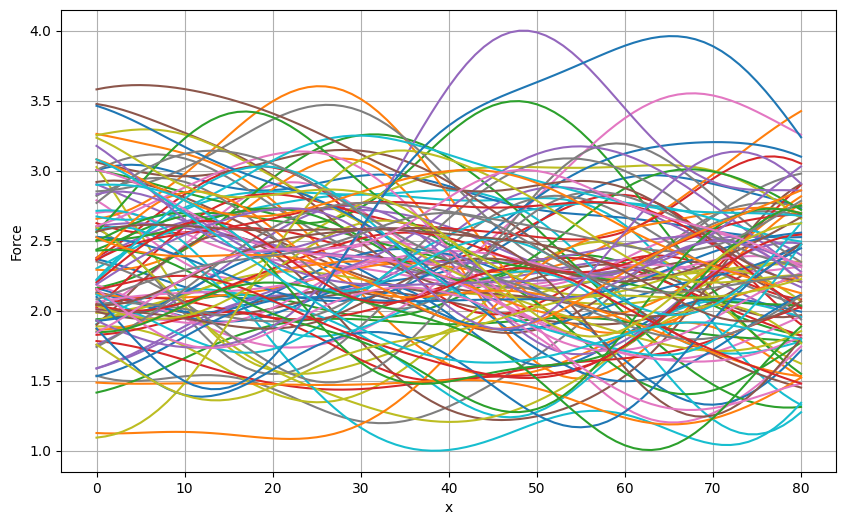

In [2]:
# Branch net의 입력 시각화 : 빔 위의 힘 분포 함수
plt.figure(figsize=(10, 6))
for i in range(branch_inputs.shape[0]):
    plt.plot(branch_inputs[i].cpu().detach().numpy().squeeze(), label=f'Branch Input {i}')

# 라벨 및 범례
plt.xlabel("x")
plt.ylabel("Force")
plt.grid(True)
plt.show()

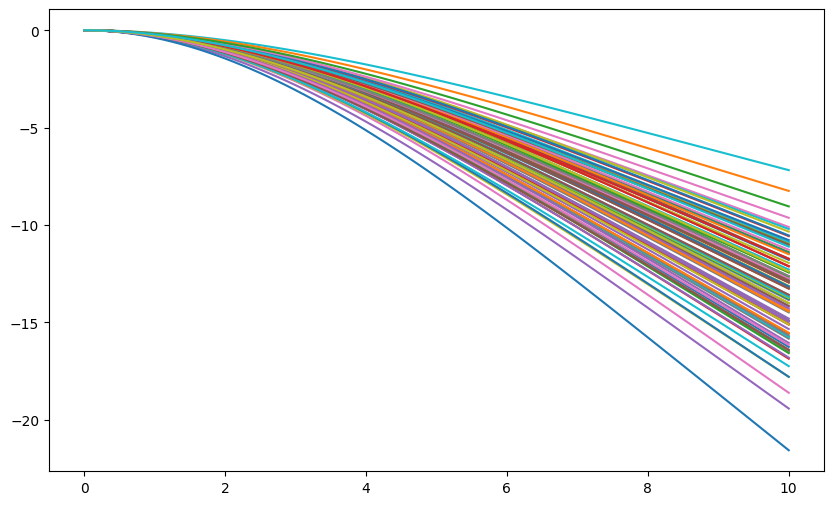

In [3]:
# FEM 해석 결과 시각화 : 빔의 변형 결과
plt.figure(figsize=(10, 6))
for i in range(deeponet_outputs.shape[0]):
    deeponet_plot = deeponet_outputs[i].cpu().detach().numpy().squeeze()
    plt.plot(np.linspace(0,10,81) , deeponet_plot, label=f'Branch Input {i}')

Text(0.5, 1.0, 'Deformation of Beam')

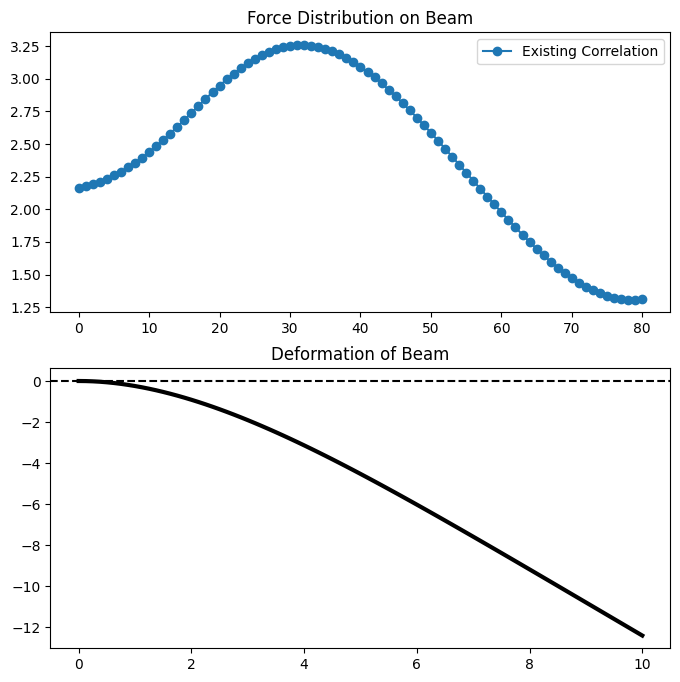

In [4]:
# 힘 분포에 따른 빔의 변형 시각화
import matplotlib.pyplot as plt
index_final = 32
branch_plot = branch_inputs[index_final].cpu().detach().numpy().squeeze()
deeponet_plot = deeponet_outputs[index_final].cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(branch_plot,'-o', label="Existing Correlation")
axes[0].set_title("Force Distribution on Beam")
axes[0].legend()

axes[1].plot(np.linspace(0,10,81), deeponet_plot, color='k',linewidth = 3 )
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_title("Deformation of Beam")

In [5]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    
    self.branch = nn.Sequential(
      nn.Linear(81, 50), nn.Tanh(),  # sensor 차원
      nn.Linear(50, 50), nn.Tanh(),
      nn.Linear(50, 40), nn.Tanh() 
    )
    self.trunk = nn.Sequential(
      nn.Linear(1, 50), nn.Tanh(),   # 노드 차원
      nn.Linear(50, 50), nn.Tanh(),
      nn.Linear(50, 40), nn.Tanh()
    )

    
  def forward(self, u, y):
    branch_out = self.branch(u)
    trunk_out  = self.trunk(y)
    out = branch_out @ trunk_out.t()
    return out, trunk_out

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight.data)
    nn.init.zeros_(m.bias)

model = Network()
model = model.to(device)
model.apply(init_weights)

# 손실 함수 및 옵티마이저
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
n_epochs = 50000
for epoch in range(n_epochs):
            
    optimizer.zero_grad()

    #forward pass through model
    pred, _= model(branch_inputs, trunk_input)    
    loss = loss_fn(pred, deeponet_outputs)

    # Backward pass
    loss.backward()
    optimizer.step()

    
    if epoch % 1000 ==0:
        print(f'Epoch: {epoch}, Loss: {float(loss):.3}')

print(f'Epoch: {epoch+1}, Final Loss: {float(loss):.3}')


Epoch: 0, Loss: 39.3
Epoch: 1000, Loss: 0.0198
Epoch: 2000, Loss: 0.0294
Epoch: 3000, Loss: 0.00505
Epoch: 4000, Loss: 0.00905
Epoch: 5000, Loss: 0.0127
Epoch: 6000, Loss: 0.0227
Epoch: 7000, Loss: 0.000766
Epoch: 8000, Loss: 0.0134
Epoch: 9000, Loss: 0.00588
Epoch: 10000, Loss: 0.0171
Epoch: 11000, Loss: 0.00299
Epoch: 12000, Loss: 0.0165
Epoch: 13000, Loss: 0.000854
Epoch: 14000, Loss: 0.00211
Epoch: 15000, Loss: 0.00507
Epoch: 16000, Loss: 0.00175
Epoch: 17000, Loss: 0.00162
Epoch: 18000, Loss: 0.0136
Epoch: 19000, Loss: 0.0015
Epoch: 20000, Loss: 0.00229
Epoch: 21000, Loss: 0.00965
Epoch: 22000, Loss: 0.00204
Epoch: 23000, Loss: 0.00662
Epoch: 24000, Loss: 0.00604
Epoch: 25000, Loss: 0.00616
Epoch: 26000, Loss: 0.00559
Epoch: 27000, Loss: 0.00132
Epoch: 28000, Loss: 0.00696
Epoch: 29000, Loss: 0.000256
Epoch: 30000, Loss: 0.000816
Epoch: 31000, Loss: 8.67e-05
Epoch: 32000, Loss: 0.00106
Epoch: 33000, Loss: 0.0127
Epoch: 34000, Loss: 0.014
Epoch: 35000, Loss: 0.00438
Epoch: 36000, L

In [7]:
_, trunk_output = model(branch_inputs, trunk_input)
print("trunk output shape:", trunk_output.shape)

trunk output shape: torch.Size([81, 40])


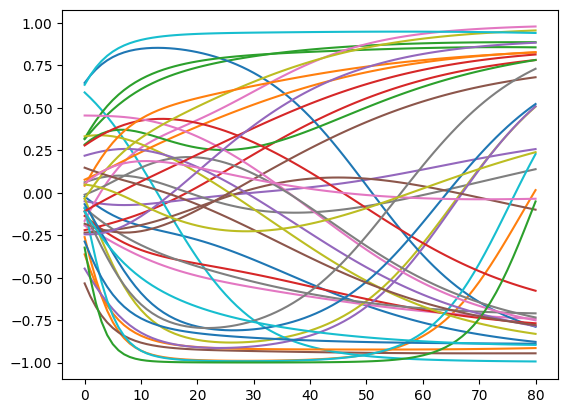

In [8]:
trunk_output_plot= trunk_output.detach().cpu().numpy()
for i in range(trunk_output_plot.shape[1]):
    plt.plot(trunk_output_plot[:,i], label=f'Trunk Output {i}')
    # plt.legend()

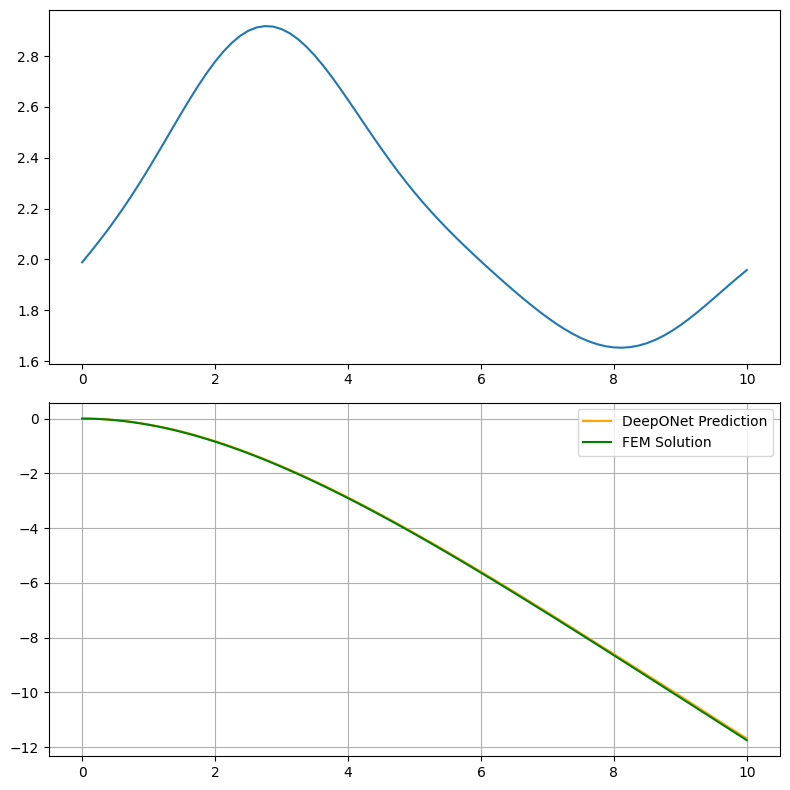

In [9]:
# 학습 데이터 검증
index_test = 6
output_pred_np, _ = model(branch_inputs, trunk_input)
output_pred_np = output_pred_np[index_test].cpu().detach().numpy()
branch_plot = branch_inputs[index_test].detach().cpu().numpy().squeeze()
solution_plot = deeponet_outputs[index_test].detach().cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(np.linspace(0,10,81), branch_plot, label='Branch Input')


axes[1].plot(np.linspace(0,10,81), output_pred_np ,color = 'orange', label='DeepONet Prediction')
axes[1].plot(np.linspace(0,10,81), solution_plot ,color = 'green', label='FEM Solution')
axes[1].legend()
axes[1].grid(True)
# 그래프 표시
plt.tight_layout()
plt.show()

# 3. DeepONet Validation

In [10]:
# Validation 데이터 불러오기
def load_training_tensors(file_path):
    data = np.load(file_path)
    branch = convert_np_to_tensor(data['force_func'])
    trunk = convert_np_to_tensor(data['existing_corr'])
    output = convert_np_to_tensor(data['boundary_corr'])
    return branch, trunk, output

branch, trunk, output = load_training_tensors("vali_data_30.npz")
vali_branch_inputs = branch.to(device)
vali_trunk_input = trunk.to(device)
vali_deeponet_outputs = output.to(device)

print("vali branch_inputs shape   :", vali_branch_inputs.shape, vali_branch_inputs.device)    # (677, 1, 81, 81)
print("vali trunk_input shape    :", vali_trunk_input.shape, vali_trunk_input.device)     # (677, 121, 2)
print("vali deeponet_outputs shape:", vali_deeponet_outputs.shape, vali_deeponet_outputs.device)     # (677, 121, 2)

vali branch_inputs shape   : torch.Size([30, 81]) cuda:0
vali trunk_input shape    : torch.Size([81, 1]) cuda:0
vali deeponet_outputs shape: torch.Size([30, 81]) cuda:0


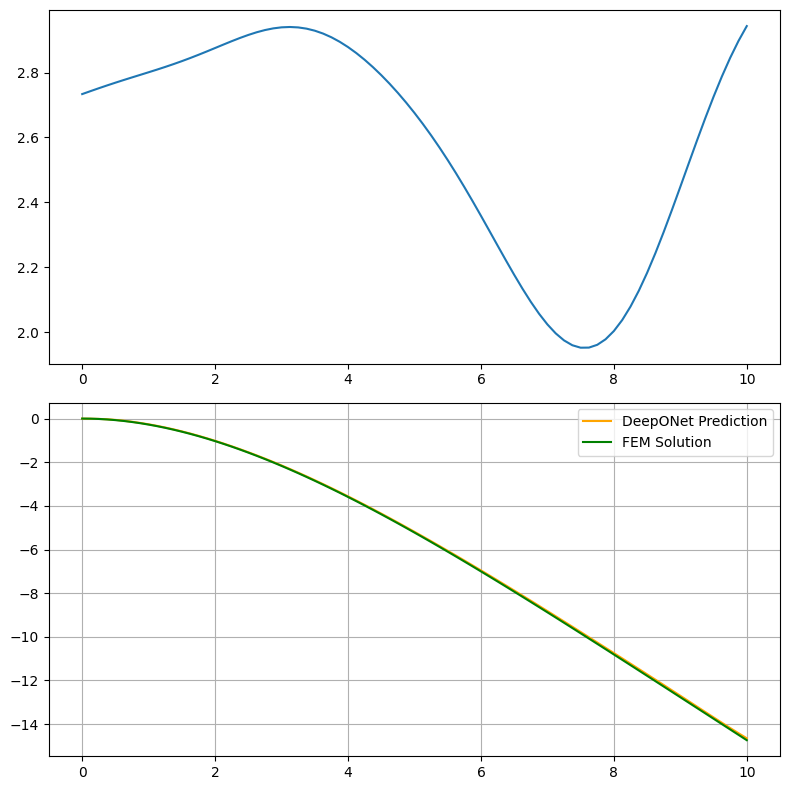

In [11]:
# 학습 데이터 검증
index_test = 28
output_pred_np, _ = model(vali_branch_inputs, vali_trunk_input)
output_pred_np = output_pred_np[index_test].cpu().detach().numpy()
branch_plot = vali_branch_inputs[index_test].detach().cpu().numpy().squeeze()
solution_plot = vali_deeponet_outputs[index_test].detach().cpu().numpy().squeeze()
X = np.linspace(0, 10, 81)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(X, branch_plot, label='Branch Input')
axes[1].plot(X, output_pred_np ,color = 'orange', label='DeepONet Prediction')
axes[1].plot(X, solution_plot ,color = 'green', label='FEM Solution')
axes[1].legend()
axes[1].grid(True)
# 그래프 표시
plt.tight_layout()
plt.show()